In [1]:
%reload_ext autoreload
%autoreload 1
from ray import tune, train
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
# data_sample_train=pl.read_parquet('data/data_sample.parquet')
# data_sample_val=pl.read_parquet('data/data_sample.parquet')
data_sample_train=pl.read_parquet('data/data_full_train.parquet')
data_sample_val=pl.read_parquet('data/data_full_val.parquet')

In [4]:
data_sample_train=dmf.title_text_features(data_sample_train)
data_sample_val=dmf.title_text_features(data_sample_val)

In [5]:
X_mini_train = data_sample_train.drop(columns=['Application Date','month','Policy Code'])
X_mini_val= data_sample_val.drop(columns=['Application Date','month','Policy Code'])
y_mini_train = data_sample_train['Policy Code']
y_mini_val= data_sample_val['Policy Code']

# stop here

In [6]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=50,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=52,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)

imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step(zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step(state_imputer, "State"),
        tr.PolarsColumnTransformer.Step(emp_length_imputer, "Employment Length"),
    ]
)

In [7]:
state_encoder = tr.TargetMeanOrderedLabeler()
zip_encoder = tr.TargetMeanOrderedLabeler()
title_encoder = tr.PolarsOneHotEncoder()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder = tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(state_encoder, "State"),
        tr.PolarsColumnTransformer.Step(zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step(title_encoder, "title"),
        tr.PolarsColumnTransformer.Step(employment_encoder, "Employment Length"),
    ]
)
null_imp = tr.PolarsNullImputer(fill_value=-9)


model_lgbm = lgb.LGBMClassifier(
    class_weight="balanced",
    force_col_wise=True,
    verbose=-1,
    num_threads=1,
    random_state=1,
)

boruta = tr.BorutaFeatureSelectorPolars(model_lgbm, random_state=1,perc=1)

preprocess_lgbm = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("null_imputer", null_imp),
        ("boruta", boruta),
    ]
)

In [8]:
full_pipeline = Pipeline(
    [
        ("preprocess", preprocess_lgbm),
        ("model", model_lgbm),
    ]
)

In [9]:
search_space_lgbm = {
    "preprocess__boruta__perc": tune.randint(1,100),
    "preprocess__boruta__apply": tune.choice([True,False]),
    "model__num_leaves": tune.randint(10, 200),
    "model__n_estimators": tune.randint(10, 250),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 1.0),
    "model__reg_lambda": tune.loguniform(0.001, 1.0),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
}

models=tunes.Models()
models.add_model('lgbm_yn',full_pipeline,search_space_lgbm)


models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=36)

(Trainable pid=43920) {'preprocess__boruta__perc': 35, 'preprocess__boruta__apply': True, 'model__num_leaves': 149, 'model__n_estimators': 230, 'model__learning_rate': 0.004087901368203431, 'model__colsample_bytree': 0.7006774803400344, 'model__subsample': 0.29896839334984815, 'model__reg_alpha': 0.11307077083494636, 'model__reg_lambda': 0.5864481457719137, 'model__boosting_type': 'rf'}


(Trainable pid=43920) Trainable.setup took 28.591 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(Trainable pid=43920) Step 0 F-1 Score: 0.5525606469002695
(Trainable pid=43920) {'preprocess__boruta__perc': 35, 'preprocess__boruta__apply': True, 'model__num_leaves': 149, 'model__n_estimators': 230, 'model__learning_rate': 0.004087901368203431, 'model__colsample_bytree': 0.7006774803400344, 'model__subsample': 0.29896839334984815, 'model__reg_alpha': 0.11307077083494636, 'model__reg_lambda': 0.5864481457719137, 'model__boosting_type': 'rf'}


(Trainable pid=44047) Trainable.setup took 29.135 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(Trainable pid=44047) {'preprocess__boruta__perc': 95, 'preprocess__boruta__apply': True, 'model__num_leaves': 92, 'model__n_estimators': 76, 'model__learning_rate': 0.0015120798815703943, 'model__colsample_bytree': 0.9868797567505296, 'model__subsample': 0.9193403464175194, 'model__reg_alpha': 0.0017649867355565866, 'model__reg_lambda': 0.33338918251969535, 'model__boosting_type': 'dart'}
(Trainable pid=44047) {'preprocess__boruta__perc': 95, 'preprocess__boruta__apply': True, 'model__num_leaves': 92, 'model__n_estimators': 76, 'model__learning_rate': 0.0015120798815703943, 'model__colsample_bytree': 0.9868797567505296, 'model__subsample': 0.9193403464175194, 'model__reg_alpha': 0.0017649867355565866, 'model__reg_lambda': 0.33338918251969535, 'model__boosting_type': 'dart'}
(Trainable pid=44047) Step 0 F-1 Score: 0.17424975798644726
(Trainable pid=44108) {'preprocess__boruta__perc': 83, 'preprocess__boruta__apply': True, 'model__num_leaves': 36, 'model__n_estimators': 80, 'model__lear

(Trainable pid=44108) Trainable.setup took 29.753 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(Trainable pid=43920) Step 1 F-1 Score: 0.5428194993412384
(Trainable pid=43920) {'preprocess__boruta__perc': 35, 'preprocess__boruta__apply': True, 'model__num_leaves': 149, 'model__n_estimators': 230, 'model__learning_rate': 0.004087901368203431, 'model__colsample_bytree': 0.7006774803400344, 'model__subsample': 0.29896839334984815, 'model__reg_alpha': 0.11307077083494636, 'model__reg_lambda': 0.5864481457719137, 'model__boosting_type': 'rf'}
(Trainable pid=44047) {'preprocess__boruta__perc': 95, 'preprocess__boruta__apply': True, 'model__num_leaves': 92, 'model__n_estimators': 76, 'model__learning_rate': 0.0015120798815703943, 'model__colsample_bytree': 0.9868797567505296, 'model__subsample': 0.9193403464175194, 'model__reg_alpha': 0.0017649867355565866, 'model__reg_lambda': 0.33338918251969535, 'model__boosting_type': 'dart'}
(Trainable pid=44108) {'preprocess__boruta__perc': 83, 'preprocess__boruta__apply': True, 'model__num_leaves': 36, 'model__n_estimators': 80, 'model__learning

(Trainable pid=44175) Trainable.setup took 29.621 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(Trainable pid=44175) Step 0 F-1 Score: 0.6438356164383562
(Trainable pid=44175) {'preprocess__boruta__perc': 26, 'preprocess__boruta__apply': False, 'model__num_leaves': 112, 'model__n_estimators': 116, 'model__learning_rate': 0.09077072234004778, 'model__colsample_bytree': 0.5633352164776549, 'model__subsample': 0.28258018615799135, 'model__reg_alpha': 0.2585014036814102, 'model__reg_lambda': 0.09958364251077013, 'model__boosting_type': 'gbdt'}
(Trainable pid=44175) Step 1 F-1 Score: 0.6448275862068965
(Trainable pid=44175) {'preprocess__boruta__perc': 26, 'preprocess__boruta__apply': False, 'model__num_leaves': 112, 'model__n_estimators': 116, 'model__learning_rate': 0.09077072234004778, 'model__colsample_bytree': 0.5633352164776549, 'model__subsample': 0.28258018615799135, 'model__reg_alpha': 0.2585014036814102, 'model__reg_lambda': 0.09958364251077013, 'model__boosting_type': 'gbdt'}
(Trainable pid=44175) Step 2 F-1 Score: 0.6273830155979203
(Trainable pid=44175) {'preprocess__bor

(Trainable pid=44229) Trainable.setup took 30.129 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


(Trainable pid=44229) Step 0 F-1 Score: 0.5520974289580515
(Trainable pid=44229) {'preprocess__boruta__perc': 9, 'preprocess__boruta__apply': False, 'model__num_leaves': 146, 'model__n_estimators': 230, 'model__learning_rate': 0.013238271626575067, 'model__colsample_bytree': 0.6469135494214725, 'model__subsample': 0.7337210416681583, 'model__reg_alpha': 0.3813161693715466, 'model__reg_lambda': 0.7062940531337437, 'model__boosting_type': 'rf'}
(Trainable pid=44229) Step 1 F-1 Score: 0.5668449197860962
(Trainable pid=44229) {'preprocess__boruta__perc': 9, 'preprocess__boruta__apply': False, 'model__num_leaves': 146, 'model__n_estimators': 230, 'model__learning_rate': 0.013238271626575067, 'model__colsample_bytree': 0.6469135494214725, 'model__subsample': 0.7337210416681583, 'model__reg_alpha': 0.3813161693715466, 'model__reg_lambda': 0.7062940531337437, 'model__boosting_type': 'rf'}
(Trainable pid=44229) Step 2 F-1 Score: 0.5743145743145743
(Trainable pid=44229) {'preprocess__boruta__per

2023-10-03 15:47:32,826	WARNING tune.py:194 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


In [ ]:
models.models['lgbm_yn'].pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=[<functions.transformers.PolarsColumnTransformer.Step object at 0x7f9c559aafd0>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9cc8176a30>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9cc8176af0>,
                                                                 <functions.transformers.PolarsColu...
                ('model',
                 LGBMClassifier(boosting_type='rf', class_weight='balanced',
                                colsample_bytree=0.5762020704530788,
                                force_col_wise=True,
                                learning_rate=0.00743321016462957,
                                n_estimators=117, num_leaves=119, num_threads=1,
                                random_state=RandomState(MT19937) at 0x7F9C51AD9940,
                                reg_alpha=0.02181494481585082,
                                reg_lambda=0.08531119879780251,
                                subsample=0.6583984975633399, verbose=-1))])

In [ ]:
models.models['lgbm_yn'].pipeline.fit(X_mini_train.sample(100000,seed=1),y_mini_train.sample(100000,seed=1))


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=[<functions.transformers.PolarsColumnTransformer.Step object at 0x7f9c559aafd0>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9cc8176a30>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9cc8176af0>,
                                                                 <functions.transformers.PolarsColu...
                ('model',
                 LGBMClassifier(boosting_type='rf', class_weight='balanced',
                                colsample_bytree=0.5762020704530788,
                                force_col_wise=True,
                                learning_rate=0.00743321016462957,
                                n_estimators=117, num_leaves=119, num_threads=1,
                                random_state=RandomState(MT19937) at 0x7F9C51AD9940,
                                reg_alpha=0.02181494481585082,
                                reg_lambda=0.08531119879780251,
                                subsample=0.6583984975633399, verbose=-1))])

In [ ]:
preds=full_pipeline.predict(X_mini_val)
# models.models['lgbm_yn'].pipeline.predict(X_mini_val)

In [ ]:
print(classification_report(y_mini_val,preds))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97   2849034
           1       0.47      0.84      0.61    148573

    accuracy                           0.95   2997607
   macro avg       0.73      0.90      0.79   2997607
weighted avg       0.97      0.95      0.95   2997607



 94%|=================== | 4718/5000 [00:14<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


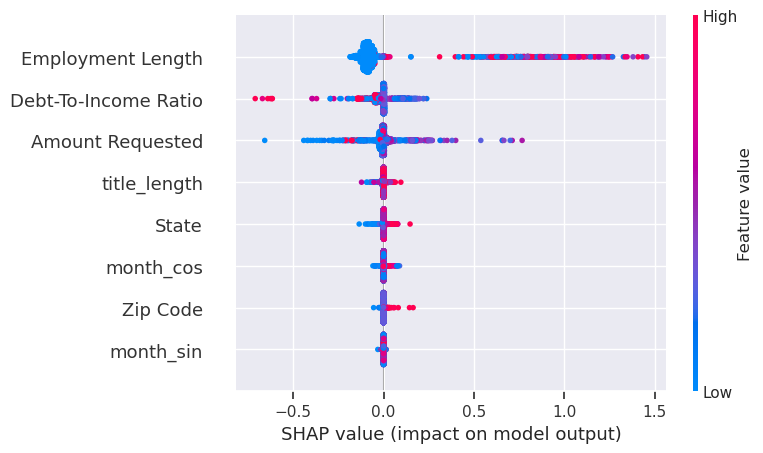

In [ ]:
names = full_pipeline["preprocess"].transform(X_mini_val.sample(5000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    full_pipeline["model"],
    data=full_pipeline["preprocess"]
    .transform((X_mini_val.sample(100, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    full_pipeline["preprocess"].transform(X_mini_val.sample(5000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    full_pipeline["preprocess"].transform(X_mini_val.sample(5000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# dtree=DecisionTreeClassifier()
# full_pipeline_dtree= Pipeline(
#     [
#         ("preprocess", Pipeline([("imputer", imputer), ("encoder", encoder), ("null_imputer", imp)])),
#         ("model", dtree),
#     ]
# )

In [ ]:
# full_pipeline_dtree.fit(X_mini_train, y_mini_train)
# preds_dtree = full_pipeline_dtree.predict(X_mini_val)
# print(classification_report(y_mini_val, preds_dtree))